# Markov Chain Analysis

This notebook tries to find if there are similarities in shopper behaviour using network analysis.

## Load dependencies

In [1]:
import pandas as pd
import numpy as np
import copy

from scipy import stats

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
matplotlib.style.use('ggplot')

import seaborn as sns
from tqdm import tqdm_notebook as tqdm

In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
from msci.utils import utils
from msci.utils.utils import data_path
from msci.analysis.networks import *
from msci.utils.plot import create_count_of_shoppers_gif, create_count_of_shoppers_image
from msci.utils.plot import plot_path_jn, plot_histogram_jn, plot_points_on_map_jn
from msci.analysis.markov_chain import *

In [ ]:
from sklearn import preprocessing
from scipy.stats import linregress

## Get data

In [ ]:
mac_address_df = utils.import_mac_addresses(version=3)
signal_df = utils.import_signals(version=4)

In [6]:
shopper_df = mac_address_df[mac_address_df.dbscan_label == 'Shopper']

In [7]:
shop_df_old = utils.import_shop_directory(mall='Mall of Mauritius', version=2)

In [8]:
shop_df1 = utils.import_shop_directory(mall='Mall of Mauritius', version=1)

shop_df = pd.merge(
    shop_df_old, 
    shop_df1[['store_id', 'store_name', 'store_category']], 
    how='left',
    on='store_id'
)

In [9]:
r_signal_df1 = signal_df[
    signal_df.store_id.notnull() & 
    (signal_df.store_id.str[0] == 'B') & 
    signal_df.mac_address.isin(shopper_df.mac_address)
].sort_values(['mac_address', 'date_time'])

In [10]:
r_signal_df = pd.merge(
    r_signal_df1, 
    shop_df[['store_id', 'store_category']], 
    how='left', 
    on='store_id'
)

r_signal_df.store_category[r_signal_df.store_category.isnull()] = 'None'

c:\users\tvb\envs\venv-msci\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Markov Chain

In [37]:
names, A, pi = markov_chain(dd_signal_df, return_permitted=False, on='store_id')

In [12]:
shop_probs_df = process(names, A, pi, shop_df, rep = 1000)
shop_probs_df.head()

,frequency,store_id,area,dimensions,centroid,x,y,count_of_shoppers,store_name,store_category,pi,piA,ss
0,138233,B87,3345.833333,"{308.5: [69.0, 92.0], 309.5: [72.5, 104.0], 31...","[318.9785048914996, 89.388654180502002]",318.978505,89.388654,15744,Intermart,Supermarket,0.062773,0.047219,0.063943
1,48621,B247,1214.833333,"{225.0: [56.0, 56.0], 231.33333333333331: [46....","[246.72877631750342, 43.35011277705793]",246.728776,43.350113,6661,Courts Mammouth,Audio/Electronic,0.051985,0.041284,0.035048
2,46538,B48,629.000000,"{128.0: [120.0, 131.0], 129.0: [119.0, 121.0],...","[118.1652126577564, 125.09122652456057]",118.165213,125.091227,4464,Cash & Carry,Audio/Electronic,0.019394,0.020783,0.025072
3,30784,B251,611.500000,"{256.0: [51.0, 58.0], 256.5: [52.0, 56.5], 258...","[266.81200190575197, 46.96101871101871]",266.812002,46.961019,5449,Manjoo,Home & Décor,0.027083,0.037637,0.039245
4,23494,B39,1718.500000,"{18.0: [102.0, 103.0], 19.0: [102.0, 103.0], 2...","[50.058532675009225, 106.37523764932889]",50.058533,106.375238,4711,Monoprix,Supermarket,0.023984,0.015758,0.015764


In [13]:
# # Output transition matrix and shop names
output = False

if output:
    np.savez(
        data_path + 'shop_markov_data', 
        shop_names=names,
        transition_matrix=A,
        initial_probabilities=pi,
    )

In [14]:
area_shop_df = shop_probs_df[(shop_probs_df.area > 0) & (shop_probs_df.pi > 0) & (shop_probs_df.count_of_shoppers > 0)]

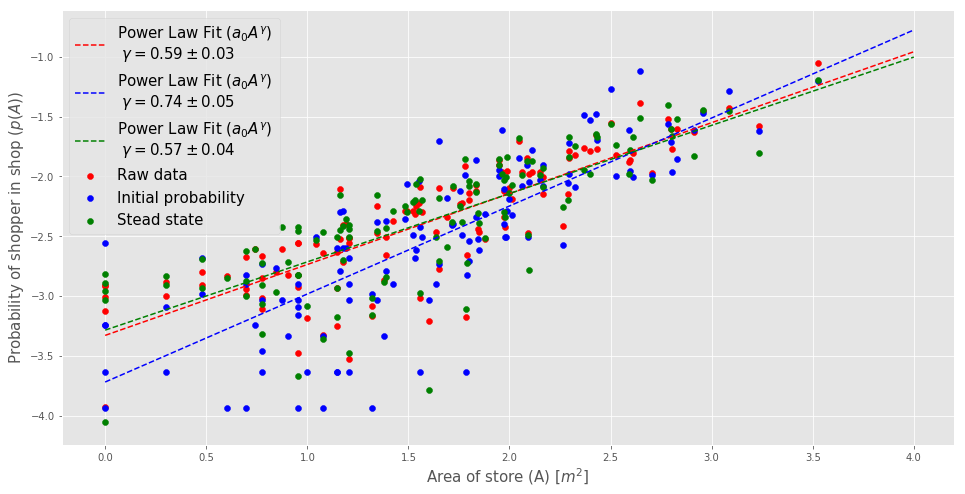

In [175]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))

x = np.log10(area_shop_df.area.tolist())
y = np.log10((area_shop_df.count_of_shoppers / sum(area_shop_df.count_of_shoppers)).tolist())
ax.scatter(x, y, c='r', label='Raw data')

slope, intercept, x_value, p_value, std_err = linregress(x, y)
x_fit = np.linspace(10**(0), 10**(4), 10)
y_fit = [10**intercept*x**slope for x in x_fit]
ax.plot(
    np.log10(x_fit), np.log10(y_fit), 
    'r--', 
    label='Power Law Fit ($a_0A^{\gamma}$) \n $\gamma=%.2f \pm %.2f$' % (slope, std_err)
)


x = np.log10(area_shop_df.area.tolist())
y = np.log10((area_shop_df.pi / sum(area_shop_df.pi)).tolist())
ax.scatter(x, y, c='b', label='Initial probability')

slope, intercept, x_value, p_value, std_err = linregress(x, y)
x_fit = np.linspace(10**(0), 10**(4), 10)
y_fit = [10**intercept*x**slope for x in x_fit]
ax.plot(
    np.log10(x_fit), np.log10(y_fit), 
    'b--', 
    label='Power Law Fit ($a_0A^{\gamma}$) \n $\gamma=%.2f \pm %.2f$' % (slope, std_err)
)


x = np.log10(area_shop_df.area.tolist())
y = np.log10((area_shop_df.ss / sum(area_shop_df.ss)).tolist())
ax.scatter(x, y, c='g', label='Stead state')

slope, intercept, x_value, p_value, std_err = linregress(x, y)
x_fit = np.linspace(10**(0), 10**(4), 10)
y_fit = [10**intercept*x**slope for x in x_fit]
ax.plot(
    np.log10(x_fit), np.log10(y_fit), 
    'g--', 
    label='Power Law Fit ($a_0A^{\gamma}$) \n $\gamma=%.2f \pm %.2f$' % (slope, std_err)
)

ax.set_xlabel('Area of store (A) [$m^2$]', fontsize=15)
ax.set_ylabel('Probability of shopper in shop ($p(A)$)', fontsize=15)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend(fontsize=15);

## Transition matrix network

In [ ]:
import networkx as nx

In [ ]:
G = nx.from_numpy_matrix(A[:20, :20], create_using=nx.MultiDiGraph())
G = nx.relabel_nodes(G, dict(enumerate(le.inverse_transform(range(len(pi[:20]))))))

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))
labels = {i : i for i in G.nodes()}
pos=nx.spring_layout(G)
nx.draw(G, pos=pos, ax=ax)
nx.draw_networkx_labels(G, pos=pos, labels=labels);

In [24]:
def remove_duplicate_stores():
    signal_mac_group = r_signal_df.groupby('mac_address')
    mac_addresses = r_signal_df.mac_address.unique()

    dd_signal = pd.DataFrame()

    for macs in tqdm(mac_addresses):
        seq = signal_mac_group.get_group(macs)
        if len(seq) > 1:
            sel = np.ones(len(seq), dtype=bool)
            seq_store = seq.store_id.as_matrix()
            sel[1:] = seq_store[1:] != seq_store[:-1]
            seq = seq[sel]
        dd_signal = pd.concat([dd_signal, seq])
        
    return dd_signal


test = remove_duplicate_stores()
# dd_signal_df = pd.concat(dd_signal)

HBox(children=(IntProgress(value=0, max=8714), HTML(value='')))

In [27]:
dd_signal_df = test

In [28]:
dd_signal_df.head()

,mac_address,wifi_type,date_time,email,store_id,location,x,y,store_category
0,00:01:da:fe:b0:8b,unknown,2016-12-22 16:39:49,unknown,B231,Mall of Mauritius,189.0,55.0,Food
1,00:02:ac:49:2d:2d,unknown,2016-12-22 20:07:39,unknown,B3,Mall of Mauritius,45.0,31.0,Clothing
2,00:02:ac:49:2d:2d,unknown,2016-12-22 20:09:41,unknown,B109,Mall of Mauritius,92.0,76.0,Clothing
4,00:02:ac:49:2d:2d,unknown,2016-12-22 20:11:13,unknown,B123,Mall of Mauritius,130.0,108.0,Footwear
5,00:02:ac:49:2d:2d,unknown,2016-12-22 20:26:05,unknown,B77,Mall of Mauritius,279.0,110.0,Specialist


In [79]:
K = 2
D = 16

pi=np.zeros(K)
b=np.zeros((2, D))
A=np.ones((2, D, D))

names, A[0], b[0] = markov_chain(
    dd_signal_df[dd_signal_df.mac_address.isin(shopper_df[shopper_df.length_of_stay < 4000].mac_address[:500])], 
    return_permitted=True, 
    on='store_category'
)

names, A[1], b[1] = markov_chain(
    dd_signal_df[dd_signal_df.mac_address.isin(shopper_df[shopper_df.length_of_stay > 11000].mac_address[500:])], 
    return_permitted=True, 
    on='store_category'
)

pi=np.array([0.5, 0.5])

In [80]:
b.round(2)

array([[ 0.  ,  0.  ,  0.1 ,  0.3 ,  0.02,  0.24,  0.06,  0.02,  0.03,
         0.05,  0.  ,  0.04,  0.01,  0.06,  0.06,  0.01],
       [ 0.  ,  0.  ,  0.08,  0.33,  0.02,  0.25,  0.03,  0.01,  0.02,
         0.04,  0.01,  0.04,  0.02,  0.05,  0.1 ,  0.  ]])

In [92]:
np.diag(A[0])

array([ 0.025     ,  0.01627287,  0.13582971,  0.37559624,  0.00334746,
        0.31495861,  0.03672746,  0.00338845,  0.00088587,  0.03618146,
        0.02506994,  0.03713298,  0.00160923,  0.03006293,  0.04698048,
        0.00194952])

In [95]:
A[0][0]

array([ 0.025 ,  0.025 ,  0.05  ,  0.1   ,  0.025 ,  0.2625,  0.0375,
        0.0375,  0.0375,  0.05  ,  0.025 ,  0.1375,  0.025 ,  0.05  ,
        0.0875,  0.025 ])

In [82]:
names, pi, b, A, gamma = markov_chain_clustering(dd_signal_df, pi, b, A, 1)

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

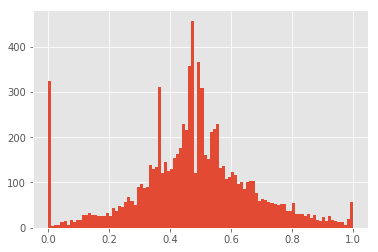

In [91]:
plt.hist(gamma[0], bins=100);

In [96]:
names, A_all, b_all = markov_chain(
    dd_signal_df, 
    return_permitted=True, 
    on='store_category'
)

In [135]:
shop_categories_df = pd.DataFrame.from_records({'store_categories': names, 'pi': b_all})
shop_categories_count_df = pd.DataFrame(shop_df.store_category.value_counts().reset_index())
shop_categories_count_df.columns = ['store_categories', 'frequency']
shop_categories_df = pd.merge(shop_categories_df, shop_categories_count_df, how='left', on='store_categories')

In [165]:
b_all = shop_categories_df.pi.as_matrix()
b_allA = A_all.T.dot(b_all).tolist()
shop_categories_df['piA'] = b_allA

In [170]:
b_all = shop_categories_df.pi.as_matrix()

for i in range(100):
    b_all = A_all.T.dot(b_all).tolist()
    
shop_categories_df['ss'] = b_all

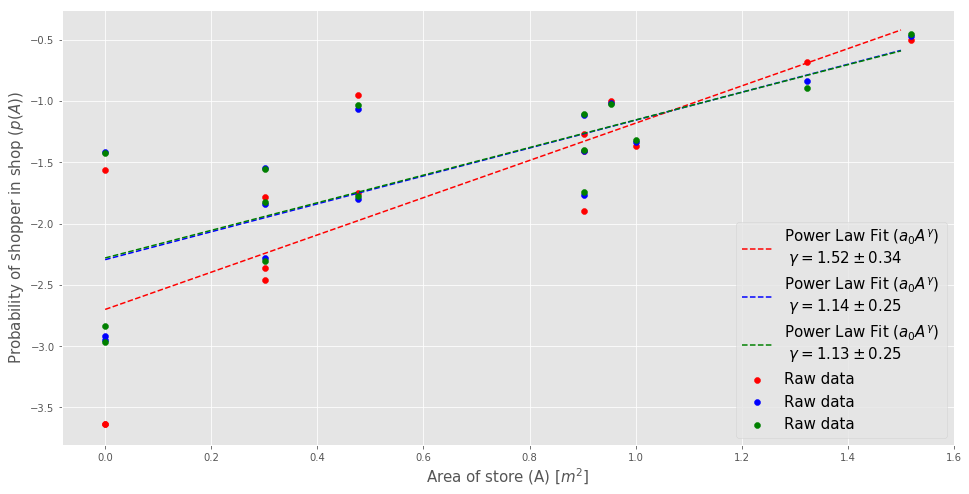

In [171]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))

values = shop_categories_df[
    shop_categories_df.frequency.notnull() &
    shop_categories_df.pi.notnull()
]

x = np.log10(values.frequency.tolist())
y = np.log10(values.pi.tolist())
ax.scatter(x, y, c='r', label='Raw data')

slope, intercept, x_value, p_value, std_err = linregress(x, y)
x_fit = np.linspace(10**0, 10**1.5, 10)
y_fit = [10**intercept*x**slope for x in x_fit]
ax.plot(
    np.log10(x_fit), np.log10(y_fit), 
    'r--', 
    label='Power Law Fit ($a_0A^{\gamma}$) \n $\gamma=%.2f \pm %.2f$' % (slope, std_err)
)


x = np.log10(values.frequency.tolist())
y = np.log10(values.piA.tolist())
ax.scatter(x, y, c='b', label='Raw data')

slope, intercept, x_value, p_value, std_err = linregress(x, y)
x_fit = np.linspace(10**0, 10**1.5, 10)
y_fit = [10**intercept*x**slope for x in x_fit]
ax.plot(
    np.log10(x_fit), np.log10(y_fit), 
    'b--', 
    label='Power Law Fit ($a_0A^{\gamma}$) \n $\gamma=%.2f \pm %.2f$' % (slope, std_err)
)


x = np.log10(values.frequency.tolist())
y = np.log10(values.ss.tolist())
ax.scatter(x, y, c='g', label='Raw data')

slope, intercept, x_value, p_value, std_err = linregress(x, y)
x_fit = np.linspace(10**0, 10**1.5, 10)
y_fit = [10**intercept*x**slope for x in x_fit]
ax.plot(
    np.log10(x_fit), np.log10(y_fit), 
    'g--', 
    label='Power Law Fit ($a_0A^{\gamma}$) \n $\gamma=%.2f \pm %.2f$' % (slope, std_err)
)

ax.set_xlabel('Area of store (A) [$m^2$]', fontsize=15)
ax.set_ylabel('Probability of shopper in shop ($p(A)$)', fontsize=15)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend(fontsize=15);

In [177]:
shop_categories_df.sort_values('ss')

,pi,store_categories,frequency,piA,ss
0,0.000230,ATM,1.0,0.001130,0.001075
1,0.000230,"Art, Antiques",1.0,0.001209,0.001447
10,0.003443,Movie & Entertainment,2.0,0.005259,0.004964
15,0.004361,Toys & Education,2.0,0.014366,0.014949
4,0.017787,Eyewear & Optomstrist,3.0,0.015776,0.016648
7,0.012738,"Hair, Health, Beauty",8.0,0.016926,0.017972
12,0.016296,Services,2.0,0.028469,0.027905
8,0.027083,Home & Décor,1.0,0.038626,0.037732
9,0.039247,Jewellery & Accessories,8.0,0.039251,0.039990
11,0.048657,None,NaN,0.051737,0.047418
